# **KNN Classifier**

In this problem you are required to train, test and validate a K-Nearest Neighbor Classifier on the famous CIFAR-10 dataset. The next few cells will guide you through the process. Follow along...

In [120]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
import os


from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
from imageio import imread
import platform

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
# Download the dataset
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2021-02-12 18:12:43--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  16.4MB/s    in 11s     

2021-02-12 18:12:55 (14.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [122]:
# This cell loads the training and testing dataset. Please note the variables at
# the end of the cell as you would require them to access the train/test data 
# and labels throughout the assignment
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
  
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Next we visualize the CIFAR-10 dataset. Although these functions are being written for you, we highly recommend you go through the code and make yourself familiar as these are things you will be required to do very often when working on AI/ML projects

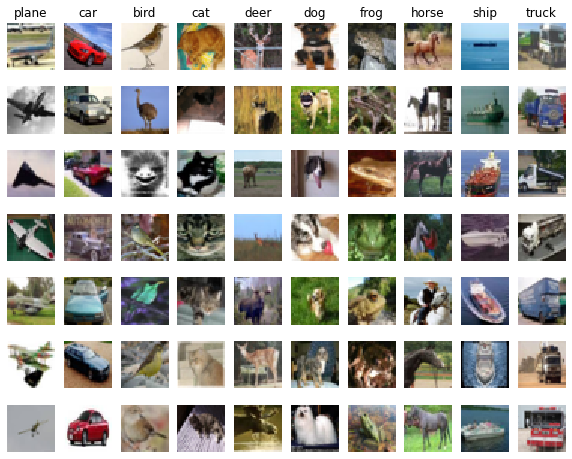

In [123]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In the next cell we flatten each image into a single dimensional vector so that it is easy to process. You should be able to reason about the dimensions comfortable.

In [124]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In the next cell you are going to implement the main KNearestNeighbor class and keep adding functions to it as and when required in the subsequent steps.

In [125]:
# You will keep coming back to this cell to add more functions as and when
# required. Right now it is very simple!
import numpy as np
import statistics 
import math
from scipy import stats as ss
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """
    
    def __init__(self):
      l=[]
      main_list_Euclidean=[]
      x_train=np.array([])
      y_train=np.array([])
    
    def train(self, X_train, y_train):
      self.x_train = X_train
      self.y_train = y_train
       
    def compute_distances_two_loops(self,x):
      dists=[]
      for i in range(len(x)):
        dists.append([])
        for j in range(len(self.x_train)):
          x1=np.subtract(self.x_train[j],x[i])
          x2=x1.dot(x1)
          x1=np.sqrt(x2)
          dists[i].append(x1)
      return np.array(dists)


    def compute_distances_no_loop(self,X_test):
      self.x_test=X_test
      x_test_x= X_test.shape[0]
      x_train_x = self.x_train.shape[0]
      dists=np.zeros((x_test_x, x_train_x))
      dists=np.sqrt( (X_test**2).sum(axis=1)[:,np.newaxis] + (self.x_train**2).sum(axis=1) - 2*X_test.dot(self.x_train.T))
      return dists
    
    def compute_distances_one_loop(self, X_test):
      
      self.x_test=X_test
      dists=np.zeros((len(X_test),len(X_train)))
      
      for i in range(len(X_test)):
          dists[i,:] = np.sum((self.x_train - X_test[i, :])**2, axis=1)
      return dists

    def predict_labels(self, dists, k):      
      final_list=[]
      i_range=500 #len(self.x_train)
      j_range=5000 #len(dists[0])
      for i in range(i_range):
        l=[]
        for j in range(j_range):
          l.append([dists[i][j] , self.y_train[j] ])
        l.sort(key=lambda a:a[0])
        l=l[:k]
        mod_list=[]
        for p in range(k):
          mod_list.append(l[p][1])
        final_list.append(float(ss.mode(mod_list)[0]))

      return final_list
    
    
    def predict_labels1(self,dists,k_set):

      labels=[]
      self.y_train=self.y_train.tolist()

      for i in range(len(self.x_test)):
        new_list=[]
        for j in range(len(dists[i])):
          new_list.append( [dists[i][j] , self.y_train[j]] )
        
        new_list.sort(key = lambda a:a[0])
        
        d={}
        count=0
        ans=0
        for i in range(k_set):
          x=new_list[i][1][0]
          if(x in d):
            d[x] = d[x] +1

          else:
            d[x]=1

          if count < d[x]:
            count = d[x]
            ans=x
        labels.append(ans)
      return labels

Go back to KNearestNeighbor class and add a method to train the classifier. Your function will be called as below. In KNN classifier, this step is a simple memorization of the training data.

In [126]:
# Make sure to add train() in the classifier class before executing this cell
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Go back to KNearestNeighbor class and add a method to compute distances between each pair of test image and train image. You can use two loops to do this. Remember we are using standard L-2 distance metric. Precisely your method should return a distance matrix($D$) where $D(i,j)$ = **L-2** distance between the $i^{th}$ test image and the $j^{th}$ train image. Your function will be called as below

In [127]:
# Make sure to add compute_distances_two_loops() in the classifier class 
# before executing this cell
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


Next implement the function to predict labels. Again go back to the KNearestNeighbor class cell. Your function will be called as below

In [128]:
# Make sure to add predict_labels() in the classifier class 
# before executing this cell 
y_test_pred = classifier.predict_labels(dists, 1) #k=1

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [129]:
# Make sure to add predict_labels() in the classifier class 
# before executing this cell
y_test_pred = classifier.predict_labels(dists, 1) #k=1

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [130]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances_no_loop(X_test)


y_test_pred = classifier.predict_labels(dists, 1) #k=1
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f for k=1' % (num_correct, num_test, accuracy))


y_test_pred = classifier.predict_labels(dists, 3) #k=3
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f for k=3' % (num_correct, num_test, accuracy))


y_test_pred = classifier.predict_labels(dists, 5) #k=5
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f for k=5' % (num_correct, num_test, accuracy))

y_test_pred = classifier.predict_labels(dists, 7) #k=7
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f for k=7' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000 for k=1
Got 136 / 500 correct => accuracy: 0.272000 for k=3
Got 139 / 500 correct => accuracy: 0.278000 for k=5
Got 137 / 500 correct => accuracy: 0.274000 for k=7


Now we have a basic classifier ready but it is extremely inefficient. In Machine Learning writing vectorised code is one of the most important skills. 

Now you have to again go back to the KNearestNeighbor class cell and add functions to compute the distance matrix using:
1.   single loop
2.   no loops

From here onwards we won't do as much hand holding as done before. You are expected to write all the code from scratch



In [131]:
# Use this cell to call the functions
# already done in the class KNearestNeighbor.

Next, you are required to tabulate the time taken to compute the distance matrix using each of the three above methods implemented for k = 1, 3, 5, 7.

In [132]:
# Use this cell to present your timing results for computing distance matrix
import time
st=time.time()
dists = classifier.compute_distances_two_loops(X_test)
print("Time required for two loop: ",time.time()-st)
st=time.time()
dists = classifier.compute_distances_one_loop(X_test)
print("Time required for one loop: ",time.time()-st)
st=time.time()
dists = classifier.compute_distances_no_loop(X_test)
print("Time required for no loop: ",time.time()-st)


Time required for two loop:  20.159482955932617
Time required for one loop:  32.32989168167114
Time required for no loop:  0.5972685813903809


As you can see that in KNN algorithm it is important to tune the hyperparameter K. We will do this using Cross Validation Leave One Out approach. The idea is to split the train set into few folds(here we recommend you to set the fold number to 5). Then, for each value of K, we leave one of these folds out to evaluate performance but use the others to train. Repeat this by leaving each fold out once. You will get 5 accuracies in this case, one for leaving out each fold. Depending on the average accuracy decide on the optimal value of K. Report the same. We also expect you to present plots showing the average accuracy for each value of K.

In [133]:
# Use this cell to implement Cross Validation


import numpy as np
y_train=y_train.reshape(-1,1)
small_x_train=np.array_split(X_train,5)
small_y_train = np.array_split(y_train,5)

K_set=[1,3,5,7]
acc_all=[]

for k in K_set:
  accuracy=[]
  for i in range(len(small_x_train)):

    x_test=[]
    Y_test=[]
    x_train=[]
    Y_train=[]

    for j in range(len(small_x_train)):
      if i==j:
        #print("Enter here")
        Y_test.extend(small_y_train[i])
        x_test.extend(small_x_train[i])

      else:
        #print("Enter here")
        Y_train.extend(small_y_train[j])
        x_train.extend(small_x_train[j])

    classifier1 = KNearestNeighbor()
    #print(Y_test)
    #print("&&&&&&&&&&&&&&&&&")
    classifier1.train(np.array(x_train),np.array(Y_train))
    #print("&&&&&&&&&&&&&&&&&")
    np_x_test=np.array(x_test)

    #print(np_x_test)

    dists = classifier1.compute_distances_no_loop(np_x_test)
    y_test_pred = classifier1.predict_labels1(dists.tolist(),k)
    #print("&&&&&&&&&&&&&&&&&")
 
    #print(len(x_test),len(y_test_pred))
    #print(len(y_test_pred),len(Y_test))
    #print("&&&&&&&&&&&&&&&&&")
 
    # Compute and print the fraction of correctly predicted examples
    #print("&&&&&&&&&&&&&&&&&")
    num_correct = 0
    for f in range(len(Y_test)):
      if y_test_pred[f] == Y_test[f]:
        num_correct=num_correct +1
    acc = float(num_correct) / num_test
    #print("&&&&&&&&&&&&&&&&&")
    #print(acc)
    #print("&&&&&&&&&&&&&&&&&")
    accuracy.append(acc)

  acc_all.append(accuracy)

#print(acc_all)


Optimal value of K : [7]


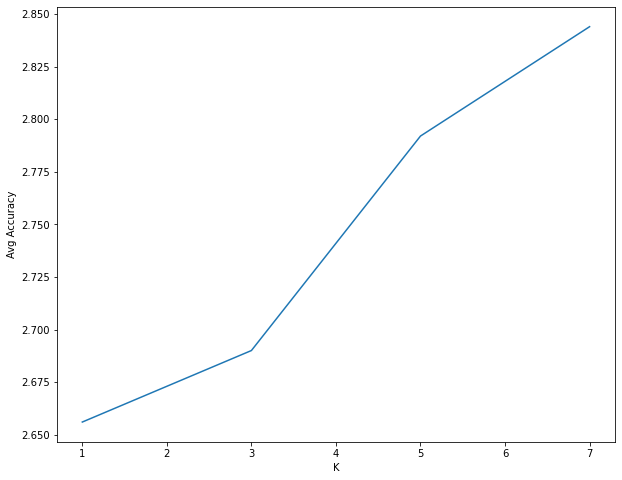

In [140]:
sumall=[]
for i in acc_all:
  s=0
  for j in i:
    s+=j
  sumall.append(s)
print("Optimal value of K :",end=" ")
print(K_set[sumall.index(max(sumall))])


#plot btw k_set vs sum_all
import matplotlib.pyplot as plt 
sumall=np.array(sumall).reshape(-1,1)
K_set=np.array(K_set).reshape(-1,1)
# x axis values = k_set
# corresponding y axis values = sumall
plt.plot(K_set, sumall)   
plt.xlabel('K') 
plt.ylabel('Avg Accuracy') 
plt.show() 

In this last part of the notebook you are expected to do the following and present appropriate reports/results:

1. What is the time complexity of training using KNN classifier? What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?

Ans.  Time complexity of training using KNN classifier : 
      2-loop : O(n*n),
      1-loop : O(n), 
      0-loop : O(1), 
      Time complexity while testing : O(n)